In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import spacy
import gensim
import nltk
import scipy
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)
from sklearn.model_selection import cross_validate
from sklearn.base import clone as sklearn_clone
from sklearn.model_selection import KFold

from tqdm import tqdm
tqdm.pandas()

import random

import sys
sys.path.append('..')

from helpers.model import (
    balance_data
)

## Load data

In [4]:
df_styl = pd.read_parquet('../datasets/used_data/02_classical_ml/04_01_political_polarization_10p_styllometric_features.parquet')
df_pos = pd.read_parquet('../datasets/used_data/02_classical_ml/04_02_political_polarization_10p_POS_ngrams.parquet')
df_ngram = pd.read_parquet('../datasets/used_data/02_classical_ml/04_03_political_polarization_10p_words_ngrams.parquet')

with open('../datasets/used_data/02_classical_ml/04_05_political_polarization_10p_herbert.npy', 'rb') as f:
    df_herbert = pd.DataFrame(np.load(f))

# with open('../datasets/used_data/02_classical_ml/04_05_political_polarization_10p_roberta.npy', 'rb') as f:
#     df_roberta = pd.DataFrame(np.load(f))

In [5]:
print(df_styl.shape, df_pos.shape, df_ngram.shape, df_herbert.shape)

(20000, 28) (20000, 3386) (20000, 3746) (20000, 1024)


In [6]:
y_train = df_styl['assestment']

In [7]:
y_train.value_counts()

assestment
0    12096
1     7904
Name: count, dtype: int64

In [8]:
df_styl.pop('assestment');
df_pos.pop('assestment');
df_ngram.pop('assestment');

## Make balanced datasets

In [10]:
X_train_u = df_styl
X_pos_u = df_pos 
X_ngram_u = df_ngram
X_herbert_u = df_herbert
# X_roberta_u = df_roberta

y_train_u = y_train 

In [11]:
words = X_ngram_u['TEXT_WORD'].str.split(' ').values
X_ngram_u.pop('TEXT_WORD');

## CV creation
### LDA

In [12]:
ideal_topic_num = 10

In [13]:
dictionary = gensim.corpora.Dictionary(words)

bow_corpus = [dictionary.doc2bow(doc) for doc in words]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(words):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

# X_train_u['topic'] = topics

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:08<00:00, 2384.48it/s]


In [14]:
x = lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

for topic,word in x:
    print(topic, word)

0 0.011*"prezydent" + 0.007*"wybory" + 0.007*"mówić" + 0.007*"powiedzieć" + 0.006*"europejski"
1 0.015*"procent" + 0.007*"ustawa" + 0.005*"projekt" + 0.005*"rząd" + 0.004*"zmiana"
2 0.016*"wiatr" + 0.011*"deszcz" + 0.011*"temperatura" + 0.010*"opad" + 0.010*"umiarkować"
3 0.007*"koronawirus" + 0.006*"zdrowie" + 0.005*"covid" + 0.005*"przypadek" + 0.005*"zakażenie"
4 0.011*"sąd" + 0.010*"policja" + 0.009*"mężczyzna" + 0.007*"sędzia" + 0.006*"miejsce"
5 0.009*"województwo" + 0.008*"bank" + 0.005*"nowy" + 0.004*"poinformować" + 0.004*"woda"
6 0.008*"mecz" + 0.007*"pierwszy" + 0.005*"miejsce" + 0.005*"drugi" + 0.005*"grać"
7 0.010*"sprawa" + 0.005*"prawo" + 0.005*"mówić" + 0.005*"prokuratura" + 0.004*"powiedzieć"
8 0.008*"granica" + 0.007*"rosja" + 0.006*"rosyjski" + 0.006*"ukraina" + 0.005*"samolot"
9 0.006*"usa" + 0.005*"amerykański" + 0.004*"kraj" + 0.003*"władza" + 0.003*"swój"


In [15]:
y_train_u_topics = pd.DataFrame(y_train_u.copy())
y_train_u_topics['topic'] = topics
y_train_u_topics['n'] = 1
y_train_u_topics.groupby(['topic', 'assestment']).sum().reset_index().pivot(index='topic',columns='assestment',values='n')

assestment,0,1
topic,,
0,1376,1534
1,988,689
2,618,221
3,1716,1223
4,2070,1129
5,497,291
6,2371,446
7,728,771
8,512,446


In [16]:
df_plot = y_train_u_topics.groupby(['topic', 'assestment']).sum().reset_index().pivot(index='topic',columns='assestment',values='n')
# df_plot[1] = -df_plot[1]

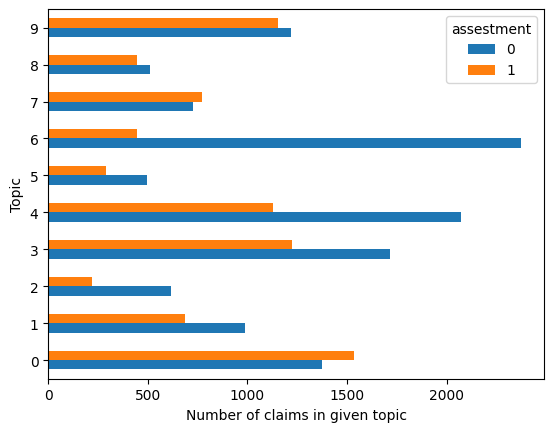

In [17]:
# Transpose the DataFrame
# df_plot = df_plot.transpose()

# Plotting bidirectional bar plot
fig, ax = plt.subplots()
df_plot.plot(kind='barh', stacked=False, ax=ax)

# Adjusting labels and legend
ax.set_ylabel('Topic')
ax.set_xlabel('Number of claims in given topic')
# ax.set_title('Bidirectional Bar Plot')
# ax.legend(title='Assessment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [30]:
# with open('../datasets/used_data/03_bert_like_models/03_topics_plytical_polarization.npy', 'wb') as f:
#     np.save(f, np.array(topics))

### Kfold

In [19]:
cv_fold = []
cv_fold_i = []

for i in y_train_u_topics['topic'].unique().reshape(10,-1):
    train_cv = X_train_u.index[ ~np.isin(y_train_u_topics["topic"], i) ].values
    test_cv = X_train_u.index[ np.isin(y_train_u_topics["topic"], i) ].values
    
    # train_cv_i = X_train_u.reset_index().index[ ~np.isin(X_train_u["topic"], i) ].values
    # test_cv_i = X_train_u.reset_index().index[ np.isin(X_train_u["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    # cv_fold_i.append( [train_cv_i, test_cv_i])

In [20]:
kf = KFold(n_splits=10, shuffle=True, random_state=111)
kf.get_n_splits(X_train_u)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(X_train_u):
    train_cv = X_train_u.iloc[ train_index, : ].index.values
    test_cv = X_train_u.iloc[ test_index, : ].index.values

    # train_cv_i= X_train_u.reset_index().iloc[ train_index, : ].index.values
    # test_cv_i = X_train_u.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    # cv_Kfold_i.append( [train_cv_i, test_cv_i])

In [21]:
# with open("../datasets/used_data/cv_fold.txt", 'w') as fp:
#     json.dump(cv_fold, fp)

## Run experiments

In [22]:
def run_experiment(X, y, cv, clf_org, r_min=0.05):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : [],
        'col_keep' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in cv:
        clf = sklearn_clone(clf_org)
        
        X_train_t = X[X.index.isin(train_cv)]
        y_train_t = y[y.index.isin(train_cv)]

        # keep only columns with corr > 0.05
        if r_min:
            col_keep = []
            for c in X_train_t.columns:
                min_v =X_train_t[c].values.min()
                max_v = X_train_t[c].values.max()
    
                if min_v < max_v:
                    r = scipy.stats.pearsonr(X_train_t[c].values, y_train_t)[0]
                    if ~np.isnan(r) and r > r_min:
                        col_keep.append(c)
            
            if len(col_keep) == 0:
                print('No values returned')
        
            X_train_t = X_train_t[col_keep]
        else:
            col_keep =  X_train_t.columns.values.tolist()


        X_test_t = X[X.index.isin(test_cv)]
        y_test_t = y[y.index.isin(test_cv)]
        
        if r_min:
            X_test_t = X_test_t[col_keep]

        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)

        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

    #     TN, FP = confusion[0, 0], confusion[0, 1]
    #     FN, TP = confusion[1, 0], confusion[1, 1]

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        results['col_keep'].append( len(col_keep)) 
    
    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
        "Precision": np.array(results['test_precision']).mean(),
        "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        "Cols used": np.array(results['col_keep']),
        }

#     print(c_matrix)

    return metrics

## Topics Kfold

In [26]:
random.seed(111)

In [27]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')
clf_lr_01 = LogisticRegression(max_iter=5000, C=0.1, penalty='l2', solver='liblinear')
clf_rf = RandomForestClassifier(random_state=111, max_depth=5)

In [28]:
for clf_used, clf_name in zip(
    [
        clf_lr_1, 
        # clf_rf, #clf_xgb
    ],[
        'lr C1', 
        # 'rf d5', #'xgb  '
    ]
):
        
    for X_used, x_name, r_min in zip(
        [X_ngram_u, 
         X_ngram_u, 
         # X_ngram_u, 
         # X_ngram_u, 
         X_train_u, 
         X_pos_u, 
         X_pos_u, 
         # X_pos_u, 
         # X_pos_u, 
         X_herbert_u
         ],
        ['ngrams  None', 
         # 'ngrams  0.01', 
         'ngrams  0.03', 
         # 'ngrams  0.05', 
         'features    ', 
         'pos     None', 
         # 'pos     0.01', 
         'pos     0.03', 
         # 'pos     0.05', 
         'herbert     '
        ],
        [None, 
         # 0.01, 
         0.03,
         # 0.05, 
         None, 
         None, 
         # 0.01, 
         0.03, 
         # 0.05, 
         None
         ]
    ):
        out = run_experiment(X_used, y_train_u, cv_fold, clf_used, r_min)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.2f}+-{out["Accuracy"].std():.2f}',
            f'F1 Score {out["F1 Score"].mean():.2f}+-{out["F1 Score"].std():.2f}',
            f'Cols used {out["Cols used"].mean().round(0):.0f}+-{out["Cols used"].std().round(0):.0f}',
            # f'Cols used {len(out["Cols used"])}',
            # f'\n\tPrecision {out["Precision"].mean():.2f}+-{out["Precision"].std():.2f}',
            # f'\n\tRecall {out["Recall"].mean():.2f}+-{out["Recall"].std():.2f}',
            # f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )
        
    print()

ngrams  None lr C1 Accuracy 0.68+-0.07 F1 Score 0.37+-0.13 Cols used 3744+-0
ngrams  0.03 lr C1 Accuracy 0.64+-0.10 F1 Score 0.19+-0.11 Cols used 411+-50
features     lr C1 Accuracy 0.61+-0.04 F1 Score 0.40+-0.08 Cols used 27+-0
pos     None lr C1 Accuracy 0.60+-0.08 F1 Score 0.12+-0.05 Cols used 3385+-0
pos     0.03 lr C1 Accuracy 0.60+-0.09 F1 Score 0.08+-0.06 Cols used 87+-15
herbert      lr C1 Accuracy 0.98+-0.01 F1 Score 0.97+-0.03 Cols used 1024+-0



## Random Kfold

In [29]:
for clf_used, clf_name in zip(
    [
        clf_lr_1, 
        # clf_rf, # clf_xgb
    ],[
        'lr C1', 
        # 'rf d5', # 'xgb  '
    ]
):
        
    for X_used, x_name, r_min in zip(
        [X_ngram_u, 
         X_ngram_u, 
         # X_ngram_u, 
         # X_ngram_u, 
         X_train_u, 
         X_pos_u, 
         X_pos_u, 
         # X_pos_u, 
         # X_pos_u, 
         X_herbert_u
         ],
        ['ngrams  None', 
         # 'ngrams  0.01', 
         'ngrams  0.03', 
         # 'ngrams  0.05', 
         'features    ', 
         'pos     None', 
         # 'pos     0.01', 
         'pos     0.03', 
         # 'pos     0.05', 
         'herbert     '
        ],
        [None, 
         # 0.01, 
         0.03,
         # 0.05, 
         None, 
         None, 
         # 0.01, 
         0.03, 
         # 0.05, 
         None
         ]
    ):
        out = run_experiment(X_used, y_train_u, cv_Kfold, clf_used, r_min)
        print(
            x_name, 
            clf_name,
            f'Accuracy {out["Accuracy"].mean():.2f}+-{out["Accuracy"].std():.2f}',
            f'F1 Score {out["F1 Score"].mean():.2f}+-{out["F1 Score"].std():.2f}',
            f'Cols used {out["Cols used"].mean().round(0):.0f}+-{out["Cols used"].std().round(0):.0f}',
            # f'Cols used {len(out["Cols used"])}',
            # f'\n\tPrecision {out["Precision"].mean():.2f}+-{out["Precision"].std():.2f}',
            # f'\n\tRecall {out["Recall"].mean():.2f}+-{out["Recall"].std():.2f}',
            # f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
        )
        
    print()

ngrams  None lr C1 Accuracy 0.72+-0.01 F1 Score 0.46+-0.01 Cols used 3744+-0
ngrams  0.03 lr C1 Accuracy 0.65+-0.01 F1 Score 0.23+-0.02 Cols used 404+-5
features     lr C1 Accuracy 0.65+-0.01 F1 Score 0.44+-0.01 Cols used 27+-0
pos     None lr C1 Accuracy 0.62+-0.01 F1 Score 0.11+-0.02 Cols used 3385+-0
pos     0.03 lr C1 Accuracy 0.61+-0.01 F1 Score 0.06+-0.01 Cols used 74+-4
herbert      lr C1 Accuracy 0.99+-0.00 F1 Score 0.98+-0.00 Cols used 1024+-0

